<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_Log_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [4]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [5]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[8] #log transformed
test_file = file_path+file[9]
dataset= "Log Transformed"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 373), (11403, 373), (75818, 373))

In [6]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [7]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [8]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [9]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished


The best auc score was 0.811
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 8.31 s, sys: 1.11 s, total: 9.42 s
Wall time: 3min 27s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                    solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Log Transformed dataset 		 



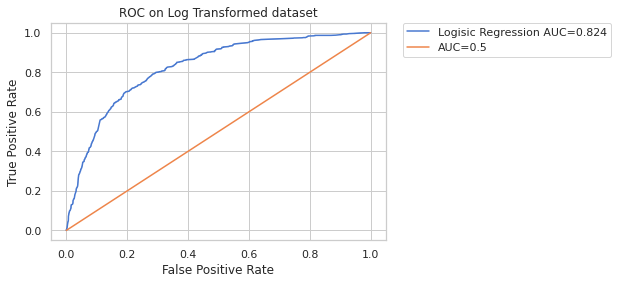

The log loss and auc was found to be 0.524 and 0.824 for Logisic Regression on Log Transformed dataset.


In [11]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [12]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061


# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished


The best auc score was 0.789
The best params were: {'min_samples_split': 500, 'min_samples_leaf': 1, 'max_leaf_nodes': 100, 'max_depth': 1000}
CPU times: user 4.72 s, sys: 223 ms, total: 4.94 s
Wall time: 5min 27s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                      splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [14]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features=None,
                                                             max_leaf_nodes=100,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=500,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
        

		 Decision Tree Classifier on Log Transformed dataset 		 



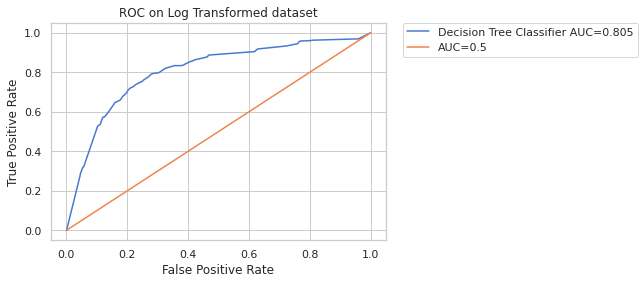

The log loss and auc was found to be 0.142 and 0.805 for Decision Tree Classifier on Log Transformed dataset.


In [15]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [16]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 67.8min finished


The best auc score was 0.821
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 6min 3s, sys: 1.09 s, total: 6min 4s
Wall time: 1h 13min 53s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 8min 40s, sys: 2.14 s, total: 8min 43s
Wall time: 4min 25s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [18]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier on Log Transformed dataset 		 



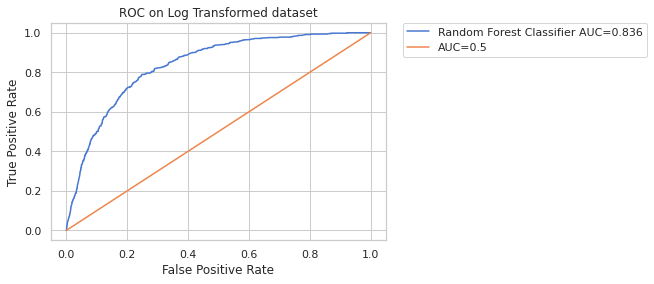

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier on Log Transformed dataset.


In [19]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [20]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274


# Selecting top features

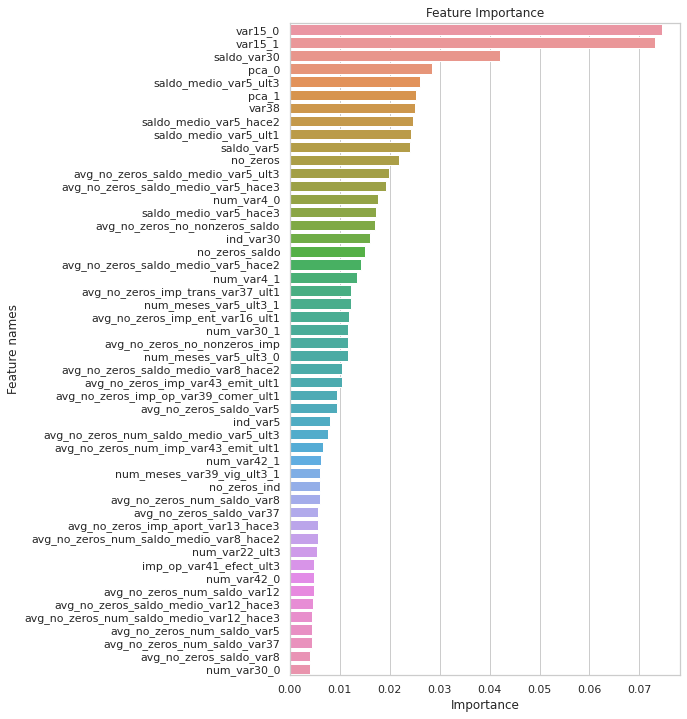

In [21]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [22]:
#getting features that have >=0.01 feature importance value.
top=0.01
features = get_top_features(X_train,model.feature_importances_,top=top)
print("There are %i features that have feature importance value above %.5f"%(len(features),top))
X_train_01 = X_train[features].copy()
X_val_01 = X_val[features].copy()
X_test_01 = X_val[features].copy()

There are 28 features that have feature importance value above 0.01000


In [23]:
#getting top k features
top=100
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_100 = X_train[features].copy()
X_val_100 = X_val[features].copy()
X_test_100 = X_val[features].copy()

Taking top 100 features


In [24]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_val[features].copy()

Taking top 250 features


# XGB Classifier

In [49]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=665,
                      reg_alpha = 0.3,
                      max_depth=5, 
                     )


In [50]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.784289	validation_0-error:0.040077
[1]	validation_0-auc:0.791093	validation_0-error:0.039639
[2]	validation_0-auc:0.805166	validation_0-error:0.039551
[3]	validation_0-auc:0.809352	validation_0-error:0.039551
[4]	validation_0-auc:0.807866	validation_0-error:0.039551
[5]	validation_0-auc:0.813041	validation_0-error:0.039551
[6]	validation_0-auc:0.81437	validation_0-error:0.039551
[7]	validation_0-auc:0.811903	validation_0-error:0.039551
[8]	validation_0-auc:0.81737	validation_0-error:0.039551
[9]	validation_0-auc:0.819135	validation_0-error:0.039551
[10]	validation_0-auc:0.818178	validation_0-error:0.039551
[11]	validation_0-auc:0.82136	validation_0-error:0.039551
[12]	validation_0-auc:0.819875	validation_0-error:0.039551
[13]	validation_0-auc:0.81838	validation_0-error:0.039551
[14]	validation_0-auc:0.817955	validation_0-error:0.039551
[15]	validation_0-auc:0.819795	validation_0-error:0.039551
[16]	validation_0-auc:0.82068	validation_0-error:0.039551
[17]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=665, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer on Log Transformed dataset 		 



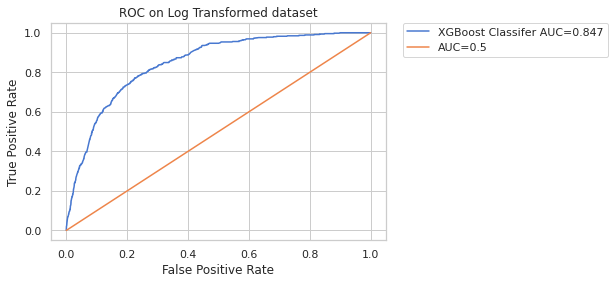

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer on Log Transformed dataset.


In [51]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [52]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274
3,XGBoost Classifer,Log Transformed,0.132578,0.847263


# LightGBM Classifier

In [71]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.7,
                      objective='binary', 
                      n_estimators=250,
                      reg_alpha = 0.3,
                      max_depth=6,
                     )


In [72]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165201	valid_0's auc: 0.78896
[2]	valid_0's binary_logloss: 0.163891	valid_0's auc: 0.817975
[3]	valid_0's binary_logloss: 0.162701	valid_0's auc: 0.81771
[4]	valid_0's binary_logloss: 0.161535	valid_0's auc: 0.827651
[5]	valid_0's binary_logloss: 0.160608	valid_0's auc: 0.826783
[6]	valid_0's binary_logloss: 0.159683	valid_0's auc: 0.828099
[7]	valid_0's binary_logloss: 0.158618	valid_0's auc: 0.832023
[8]	valid_0's binary_logloss: 0.157846	valid_0's auc: 0.830857
[9]	valid_0's binary_logloss: 0.156994	valid_0's auc: 0.832267
[10]	valid_0's binary_logloss: 0.156067	valid_0's auc: 0.83439
[11]	valid_0's binary_logloss: 0.155359	valid_0's auc: 0.833924
[12]	valid_0's binary_logloss: 0.154665	valid_0's auc: 0.834714
[13]	valid_0's binary_logloss: 0.154068	valid_0's auc: 0.833679
[14]	valid_0's binary_logloss: 0.153404	valid_0's auc: 0.834477
[15]	valid_0's binary_logloss: 0.152727	valid_0's auc: 0.83523
[16]	valid_0's binary_logloss: 0.152178	valid_0's auc

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.02, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=250, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.3,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Log Transformed dataset 		 



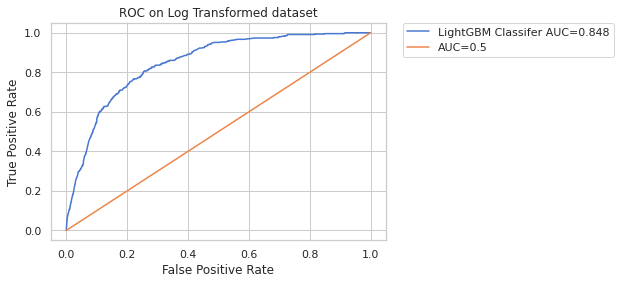

The log loss and auc was found to be 0.133 and 0.848 for LightGBM Classifer on Log Transformed dataset.


In [73]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [74]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274
3,XGBoost Classifer,Log Transformed,0.132578,0.847263
4,LightGBM Classifer,Log Transformed,0.132689,0.847950


# Random Forest (feature importance>0.01)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_01)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 30.6min finished


The best auc score was 0.821
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 1min 28s, sys: 263 ms, total: 1min 28s
Wall time: 32min 2s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_01,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [76]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_01,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (feature importance>0.01) on Log Transformed dataset 		 



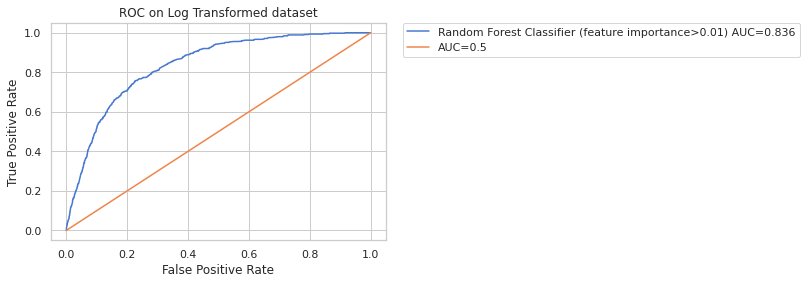

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (feature importance>0.01) on Log Transformed dataset.


In [77]:
i+=1
y_pred = cc_model.predict_proba(X_val_01)[:,1]
label="Random Forest Classifier (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [78]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274
3,XGBoost Classifer,Log Transformed,0.132578,0.847263
4,LightGBM Classifer,Log Transformed,0.132689,0.847950
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136593,0.836486


# XGB Classifier (feature importance>0.01)

In [97]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.6,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=487,
                      reg_alpha = 0.4,
                      max_depth=5, 
                     )

In [98]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.781683	validation_0-error:0.039551
[1]	validation_0-auc:0.80545	validation_0-error:0.039551
[2]	validation_0-auc:0.817752	validation_0-error:0.039551
[3]	validation_0-auc:0.821882	validation_0-error:0.039551
[4]	validation_0-auc:0.821199	validation_0-error:0.039551
[5]	validation_0-auc:0.820554	validation_0-error:0.039551
[6]	validation_0-auc:0.820336	validation_0-error:0.039551
[7]	validation_0-auc:0.820408	validation_0-error:0.039551
[8]	validation_0-auc:0.822578	validation_0-error:0.039551
[9]	validation_0-auc:0.822994	validation_0-error:0.039551
[10]	validation_0-auc:0.822929	validation_0-error:0.039551
[11]	validation_0-auc:0.823849	validation_0-error:0.039551
[12]	validation_0-auc:0.823706	validation_0-error:0.039551
[13]	validation_0-auc:0.823074	validation_0-error:0.039551
[14]	validation_0-auc:0.824026	validation_0-error:0.039551
[15]	validation_0-auc:0.823211	validation_0-error:0.039551
[16]	validation_0-auc:0.823028	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=487, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer(feature importance>0.01) on Log Transformed dataset 		 



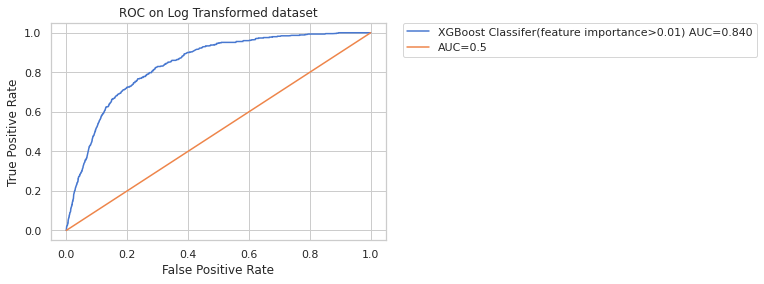

The log loss and auc was found to be 0.135 and 0.840 for XGBoost Classifer(feature importance>0.01) on Log Transformed dataset.


In [99]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="XGBoost Classifer(feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [100]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274
3,XGBoost Classifer,Log Transformed,0.132578,0.847263
4,LightGBM Classifer,Log Transformed,0.132689,0.847950
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136593,0.836486
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134801,0.840322


# LightGBM Classifier (feature importance>0.01)

In [124]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=7,
                      gamma=5
                     )

In [125]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165836	valid_0's auc: 0.80682
[2]	valid_0's binary_logloss: 0.165144	valid_0's auc: 0.823552
[3]	valid_0's binary_logloss: 0.164542	valid_0's auc: 0.823524
[4]	valid_0's binary_logloss: 0.163862	valid_0's auc: 0.829201
[5]	valid_0's binary_logloss: 0.163244	valid_0's auc: 0.829831
[6]	valid_0's binary_logloss: 0.162702	valid_0's auc: 0.828907
[7]	valid_0's binary_logloss: 0.162146	valid_0's auc: 0.828446
[8]	valid_0's binary_logloss: 0.161583	valid_0's auc: 0.828952
[9]	valid_0's binary_logloss: 0.161051	valid_0's auc: 0.829063
[10]	valid_0's binary_logloss: 0.160519	valid_0's auc: 0.829508
[11]	valid_0's binary_logloss: 0.160115	valid_0's auc: 0.829487
[12]	valid_0's binary_logloss: 0.159724	valid_0's auc: 0.829079
[13]	valid_0's binary_logloss: 0.159261	valid_0's auc: 0.829198
[14]	valid_0's binary_logloss: 0.158851	valid_0's auc: 0.828793
[15]	valid_0's binary_logloss: 0.158454	valid_0's auc: 0.828699
[16]	valid_0's binary_logloss: 0.158093	valid_0's 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer (feature importance>0.01) on Log Transformed dataset 		 



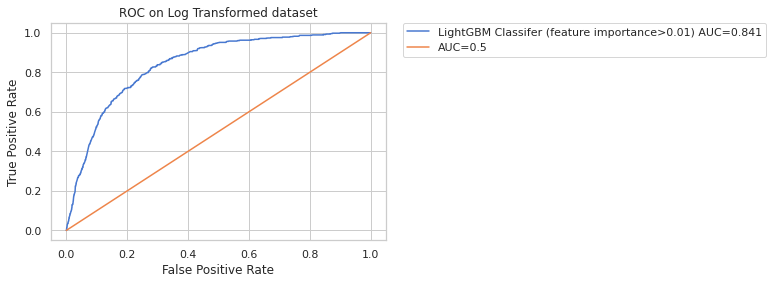

The log loss and auc was found to be 0.135 and 0.841 for LightGBM Classifer (feature importance>0.01) on Log Transformed dataset.


In [126]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="LightGBM Classifer (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [127]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274
3,XGBoost Classifer,Log Transformed,0.132578,0.847263
4,LightGBM Classifer,Log Transformed,0.132689,0.847950
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136593,0.836486
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134801,0.840322
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134635,0.841497


# Random Forest (top 100)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 38.2min finished


The best auc score was 0.824
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 2min 1s, sys: 367 ms, total: 2min 1s
Wall time: 40min 15s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [128]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_100,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [129]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_100,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (top 100) on Log Transformed dataset 		 



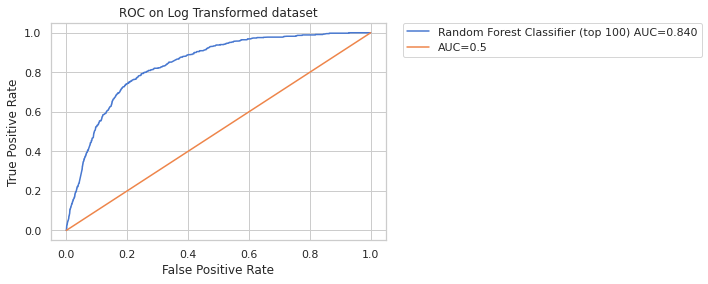

The log loss and auc was found to be 0.136 and 0.840 for Random Forest Classifier (top 100) on Log Transformed dataset.


In [130]:
i+=1
y_pred = cc_model.predict_proba(X_val_100)[:,1]
label="Random Forest Classifier (top 100)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [131]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274
3,XGBoost Classifer,Log Transformed,0.132578,0.847263
4,LightGBM Classifer,Log Transformed,0.132689,0.847950
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136593,0.836486
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134801,0.840322
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134635,0.841497
8,Random Forest Classifier (top 100),Log Transformed,0.135663,0.839784


# XGB Classifier (top 100)

In [150]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,#
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=0,
                     )


In [151]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.816275	validation_0-error:0.039639
[1]	validation_0-auc:0.826059	validation_0-error:0.039551
[2]	validation_0-auc:0.826374	validation_0-error:0.039551
[3]	validation_0-auc:0.82532	validation_0-error:0.039551
[4]	validation_0-auc:0.825558	validation_0-error:0.039551
[5]	validation_0-auc:0.826068	validation_0-error:0.039551
[6]	validation_0-auc:0.828655	validation_0-error:0.039551
[7]	validation_0-auc:0.826395	validation_0-error:0.039551
[8]	validation_0-auc:0.826162	validation_0-error:0.039551
[9]	validation_0-auc:0.82565	validation_0-error:0.039551
[10]	validation_0-auc:0.823912	validation_0-error:0.039551
[11]	validation_0-auc:0.824918	validation_0-error:0.039551
[12]	validation_0-auc:0.826874	validation_0-error:0.039551
[13]	validation_0-auc:0.826785	validation_0-error:0.039551
[14]	validation_0-auc:0.828155	validation_0-error:0.039551
[15]	validation_0-auc:0.828154	validation_0-error:0.039551
[16]	validation_0-auc:0.827749	validation_0-error:0.039551
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

		 XGBoost Classifer(top 100) on Log Transformed dataset 		 



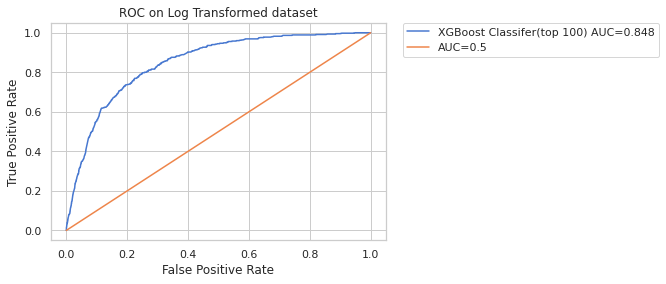

The log loss and auc was found to be 0.133 and 0.848 for XGBoost Classifer(top 100) on Log Transformed dataset.


In [152]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="XGBoost Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [153]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274
3,XGBoost Classifer,Log Transformed,0.132578,0.847263
4,LightGBM Classifer,Log Transformed,0.132689,0.847950
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136593,0.836486
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134801,0.840322
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134635,0.841497
8,Random Forest Classifier (top 100),Log Transformed,0.135663,0.839784
9,XGBoost Classifer(top 100),Log Transformed,0.132617,0.848062


# LightGBM Classifier (top 100)

In [168]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = .8,
                      objective='binary', 
                      n_estimators=947,
                      reg_alpha = 0.4,
                      max_depth=6 
                     )


In [169]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165767	valid_0's auc: 0.81495
[2]	valid_0's binary_logloss: 0.165088	valid_0's auc: 0.819849
[3]	valid_0's binary_logloss: 0.164453	valid_0's auc: 0.818525
[4]	valid_0's binary_logloss: 0.163846	valid_0's auc: 0.823404
[5]	valid_0's binary_logloss: 0.1632	valid_0's auc: 0.828825
[6]	valid_0's binary_logloss: 0.162597	valid_0's auc: 0.831156
[7]	valid_0's binary_logloss: 0.161992	valid_0's auc: 0.831872
[8]	valid_0's binary_logloss: 0.161496	valid_0's auc: 0.83071
[9]	valid_0's binary_logloss: 0.160959	valid_0's auc: 0.832378
[10]	valid_0's binary_logloss: 0.160428	valid_0's auc: 0.833066
[11]	valid_0's binary_logloss: 0.159953	valid_0's auc: 0.832526
[12]	valid_0's binary_logloss: 0.159448	valid_0's auc: 0.833432
[13]	valid_0's binary_logloss: 0.158952	valid_0's auc: 0.833998
[14]	valid_0's binary_logloss: 0.158553	valid_0's auc: 0.833158
[15]	valid_0's binary_logloss: 0.158107	valid_0's auc: 0.832847
[16]	valid_0's binary_logloss: 0.157719	valid_0's auc

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=947, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.4,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 100) on Log Transformed dataset 		 



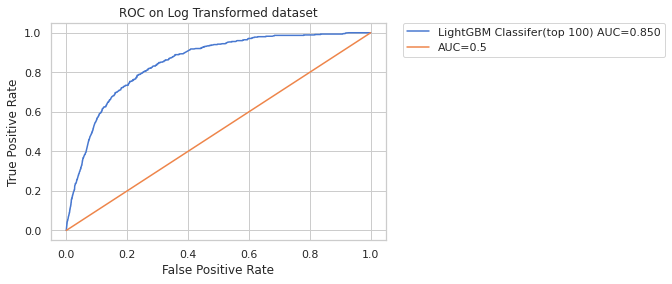

The log loss and auc was found to be 0.132 and 0.850 for LightGBM Classifer(top 100) on Log Transformed dataset.


In [170]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="LightGBM Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [171]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274
3,XGBoost Classifer,Log Transformed,0.132578,0.847263
4,LightGBM Classifer,Log Transformed,0.132689,0.847950
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136593,0.836486
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134801,0.840322
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134635,0.841497
8,Random Forest Classifier (top 100),Log Transformed,0.135663,0.839784
9,XGBoost Classifer(top 100),Log Transformed,0.132617,0.848062


# Random Forest (top 250)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 59.3min finished


The best auc score was 0.822
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 2min 46s, sys: 431 ms, total: 2min 47s
Wall time: 1h 2min 4s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [173]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [174]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (top 250) on Log Transformed dataset 		 



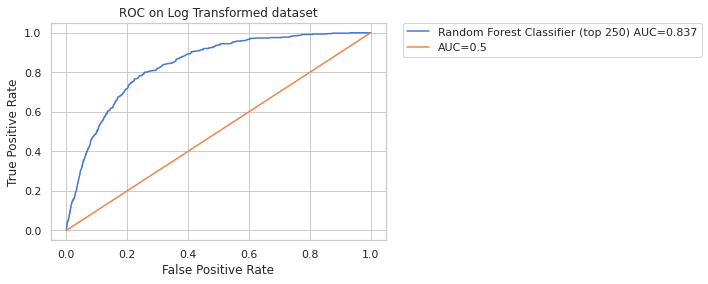

The log loss and auc was found to be 0.136 and 0.837 for Random Forest Classifier (top 250) on Log Transformed dataset.


In [175]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [176]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274
3,XGBoost Classifer,Log Transformed,0.132578,0.847263
4,LightGBM Classifer,Log Transformed,0.132689,0.847950
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136593,0.836486
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134801,0.840322
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134635,0.841497
8,Random Forest Classifier (top 100),Log Transformed,0.135663,0.839784
9,XGBoost Classifer(top 100),Log Transformed,0.132617,0.848062


# XGB Classifier (top 250)

In [197]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0.3,
                      max_depth=5,
                      gamma=0,
                     )

In [198]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.78832	validation_0-error:0.040077
[1]	validation_0-auc:0.804336	validation_0-error:0.039639
[2]	validation_0-auc:0.818415	validation_0-error:0.039551
[3]	validation_0-auc:0.819656	validation_0-error:0.039551
[4]	validation_0-auc:0.819215	validation_0-error:0.039551
[5]	validation_0-auc:0.820177	validation_0-error:0.039551
[6]	validation_0-auc:0.821489	validation_0-error:0.039551
[7]	validation_0-auc:0.820842	validation_0-error:0.039551
[8]	validation_0-auc:0.82132	validation_0-error:0.039551
[9]	validation_0-auc:0.82256	validation_0-error:0.039551
[10]	validation_0-auc:0.824063	validation_0-error:0.039551
[11]	validation_0-auc:0.82371	validation_0-error:0.039551
[12]	validation_0-auc:0.824936	validation_0-error:0.039551
[13]	validation_0-auc:0.824775	validation_0-error:0.039551
[14]	validation_0-auc:0.824066	validation_0-error:0.039551
[15]	validation_0-auc:0.824935	validation_0-error:0.039551
[16]	validation_0-auc:0.825016	validation_0-error:0.039551
[17]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Log Transformed dataset 		 



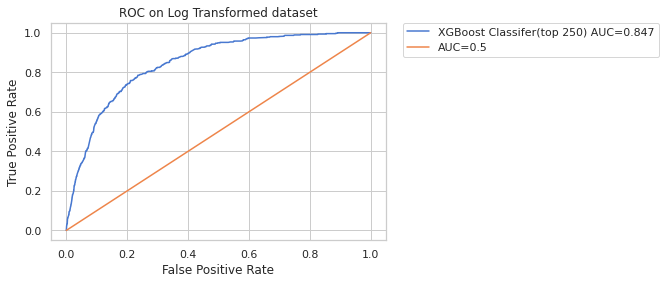

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 250) on Log Transformed dataset.


In [199]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [200]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.523875,0.824061
1,Decision Tree Classifier,Log Transformed,0.141528,0.804953
2,Random Forest Classifier,Log Transformed,0.136779,0.836274
3,XGBoost Classifer,Log Transformed,0.132578,0.847263
4,LightGBM Classifer,Log Transformed,0.132689,0.847950
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136593,0.836486
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134801,0.840322
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134635,0.841497
8,Random Forest Classifier (top 100),Log Transformed,0.135663,0.839784
9,XGBoost Classifer(top 100),Log Transformed,0.132617,0.848062


# LightGBM Classifier (top 250)

In [219]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5, 
                      subsample = .8,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = .3,
                      max_depth=5  
                     )
#valid_0's auc: 0.84687

In [220]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165798	valid_0's auc: 0.808439
[2]	valid_0's binary_logloss: 0.165104	valid_0's auc: 0.813235
[3]	valid_0's binary_logloss: 0.164446	valid_0's auc: 0.818673
[4]	valid_0's binary_logloss: 0.163829	valid_0's auc: 0.81763
[5]	valid_0's binary_logloss: 0.163278	valid_0's auc: 0.820171
[6]	valid_0's binary_logloss: 0.162766	valid_0's auc: 0.81936
[7]	valid_0's binary_logloss: 0.162269	valid_0's auc: 0.820948
[8]	valid_0's binary_logloss: 0.161746	valid_0's auc: 0.8211
[9]	valid_0's binary_logloss: 0.161229	valid_0's auc: 0.82005
[10]	valid_0's binary_logloss: 0.160718	valid_0's auc: 0.821201
[11]	valid_0's binary_logloss: 0.160221	valid_0's auc: 0.821734
[12]	valid_0's binary_logloss: 0.159718	valid_0's auc: 0.824956
[13]	valid_0's binary_logloss: 0.159255	valid_0's auc: 0.826853
[14]	valid_0's binary_logloss: 0.158816	valid_0's auc: 0.827594
[15]	valid_0's binary_logloss: 0.158352	valid_0's auc: 0.828668
[16]	valid_0's binary_logloss: 0.157894	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=447, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.3,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Log Transformed dataset 		 



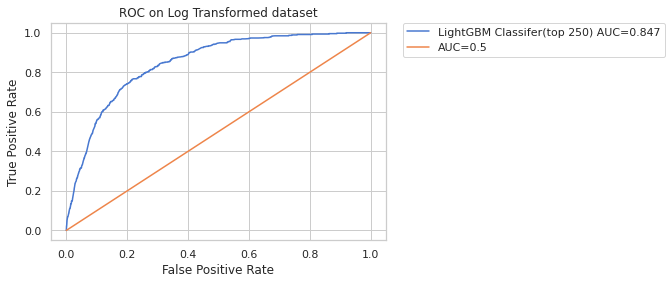

The log loss and auc was found to be 0.133 and 0.847 for LightGBM Classifer(top 250) on Log Transformed dataset.


In [221]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

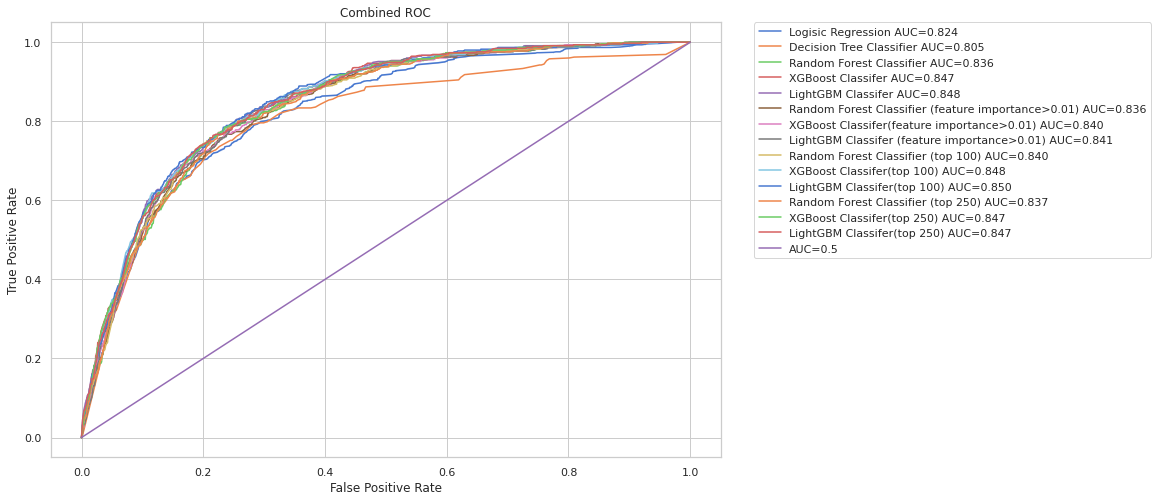

In [222]:
plot_auc(y_val,y_preds,labels)

In [225]:
result_df.sort_values(by='auc',ascending=False)

,Model,Dataset,log_loss,auc
10,LightGBM Classifer(top 100),Log Transformed,0.132104,0.849917
9,XGBoost Classifer(top 100),Log Transformed,0.132617,0.848062
4,LightGBM Classifer,Log Transformed,0.132689,0.847950
3,XGBoost Classifer,Log Transformed,0.132578,0.847263
13,LightGBM Classifer(top 250),Log Transformed,0.133162,0.846870
12,XGBoost Classifer(top 250),Log Transformed,0.132970,0.846615
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134635,0.841497
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134801,0.840322
8,Random Forest Classifier (top 100),Log Transformed,0.135663,0.839784
11,Random Forest Classifier (top 250),Log Transformed,0.136444,0.837359
